In [1]:
import os
import mcmc
import emcee

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from brick.azr import AZR

from tqdm import tqdm
from multiprocessing import Pool

# Restrict processes to one thread only
os.environ['OMP_NUM_THREADS'] = '1'

# emcee variables
nsteps = 10000 # How many steps should each walker take?
nthin  = 1     # How often should the walker save a step?
nprocs = 20    # How many Python processes do you want to allocate?

# Define the data labels (in AZURE2 order)
labels = ["Meyer et al. (1976) - 84.3 deg",
          "Meyer et al. (1976) - 114.5 deg",
          "Meyer et al. (1976) - 144.1 deg", 
          "LUNA HPGe (2023)", 
          "LUNA BGO (2023)",
          "Felsenkeller (2023)",
          "ATOMKI (2023)",
          "Notre Dame (2023) - 0 deg",
          "Notre Dame (2023) - 55 deg",
          "Burtebaev et al. (2008)",
          "Lamb et al. (1957)",
          "Bailey et al. (1950)",
          "Vogl et al. (1963)",
          "Rolfs et al. (1974) - 0 deg",
          "Rolfs et al. (1974) - 90 deg"]

In [2]:
# We read the .azr file and set the external capture file to speed up the calculation
azr = AZR('12c_pg.azr')
azr.ext_capture_file ='output/intEC.dat'

# We get the initial values from AZURE2
theta0  = azr.config.get_input_values()
ntheta  = len(theta0)
nparams = len(azr.config.parameters)

# number of walkers = 2 * number of sampled parameters
nw = 2 * ntheta

In [3]:
# We'll read the data from the output file since it's already in the center-of-mass frame
data    = np.vstack([np.loadtxt('output/'+f) for f in azr.config.data.output_files])
x       = data[:, 0]
y       = data[:, 5]
dy_bare = data[:, 6]

In [4]:
# Preparing initial parameters for the walkers
p0 = np.zeros((nw, ntheta))
mean, std = np.loadtxt('minuit/best_lnl.txt')[:,0], np.loadtxt('minuit/best_lnl.txt')[:,1]
for i in range(nw): p0[i, :] = stats.norm(mean, std).rvs()

In [5]:
backend = emcee.backends.HDFBackend('mcmc/samples.h5') 
backend.reset(nw, ntheta)

with Pool(processes=nprocs) as pool:
    sampler = emcee.EnsembleSampler(nw, ntheta, mcmc.lnP, pool=pool, backend=backend) 
    state = sampler.run_mcmc(p0, nsteps, thin_by=nthin, progress=True, tune=True)

100%|██████████| 1000/1000 [6:20:17<00:00, 22.82s/it]   


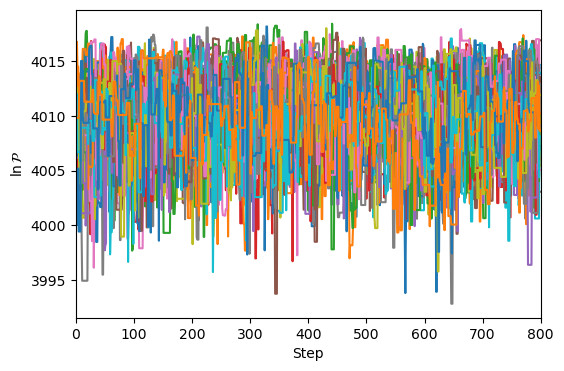

In [13]:
# Plot posterior value for each walker
lnp   = backend.get_log_prob(discard=200)
ii    = np.where(np.median(lnp, axis=0)!=-np.inf)[0]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(lnp[:, ii])
ax.set_ylabel('$\ln\mathcal{P}$')
ax.set_xlabel('Step')
ax.set_xlim([0,800])
plt.show()

  $C_{1,1}^{(-0.5)}$  1.6448 + 0.0352 - 0.0324
  $E_{1,1}^{(+0.5)}$  2.3682 + 0.0001 - 0.0001
$\Gamma_{1,1}^{(+0.5)}$ 35829.1230 +128.5360 -138.4893
$\Gamma_{1,2}^{(+0.5)}$ -0.4915 + 0.0098 - 0.0139
$\Gamma_{2,2}^{(+0.5)}$ -5940.7025 +1773.8685 -2335.5374
  $E_{1,1}^{(-1.5)}$  3.5065 + 0.0001 - 0.0001
$\Gamma_{1,1}^{(-1.5)}$ 54754.1524 +291.4244 -311.7097
$\Gamma_{1,2}^{(-1.5)}$ -0.4665 + 0.0119 - 0.0157
$\Gamma_{1,3}^{(-1.5)}$  0.0007 + 0.0003 - 0.0003
$\Gamma_{2,2}^{(-1.5)}$ -166.1614 +27.6386 -25.3540
$\Gamma_{2,3}^{(-1.5)}$ -718.4549 +356.2801 -482.8479
  $E_{1,1}^{(+2.5)}$  3.5476 + 0.0002 - 0.0002
$\Gamma_{1,1}^{(+2.5)}$ 47087.0397 +452.0915 -515.9724
             $n_{1}$  1.0220 + 0.0051 - 0.0056
             $n_{2}$  1.0081 + 0.0041 - 0.0040
             $n_{3}$  1.0048 + 0.0031 - 0.0033
             $n_{4}$  1.0961 + 0.0294 - 0.0219
             $n_{5}$  1.0862 + 0.0314 - 0.0194
             $n_{6}$  1.1297 + 0.0323 - 0.0222
             $n_{7}$  1.0854 + 0.0489 - 0.0417
     

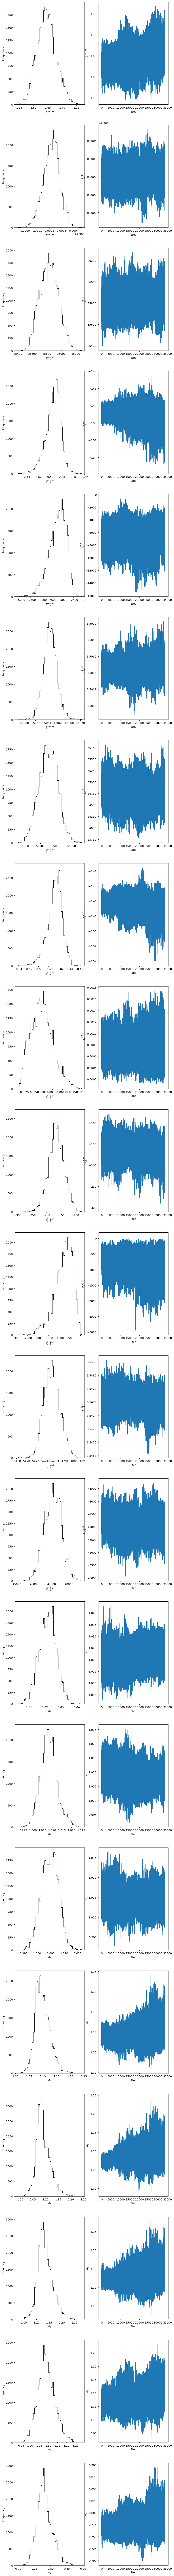

In [45]:
cut_chain = backend.get_chain(discard=200)
chain = cut_chain[:, ii, :].reshape(-1, len(azr.config.labels))

# Write the results.
best, err_neg, err_pos = np.zeros(ntheta), np.zeros(ntheta), np.zeros(ntheta)
for i in range(ntheta):
    result = np.percentile(chain[:, i], [16, 50, 84])
    q = np.diff(result)
    best[i], err_neg[i], err_pos = result[1], q[0] , q[1]
    print( "{:20s} {:7.4f} +{:7.4f} -{:7.4f}".format(azr.config.labels[i], result[1], q[1], q[0]) )

#np.savetxt('mcmc/best_lnl.txt', np.transpose([best, err_neg, err_pos]), fmt='%1.4e %1.4e %1.4e')

In [ ]:
# Plot histograms for each parameter
fig, ax = plt.subplots(ntheta, 2, figsize=(10, 5*ntheta))
for i in range(ntheta):
    ax[i, 0].hist(chain[:, i], bins=50, histtype='step', color='k')
    ax[i, 0].set_xlabel(azr.config.labels[i])
    ax[i, 0].set_ylabel('Frequency')
    ax[i, 1].plot(chain[:, i])
    ax[i, 1].set_xlabel('Step')
    ax[i, 1].set_ylabel(azr.config.labels[i])

<Axes: >

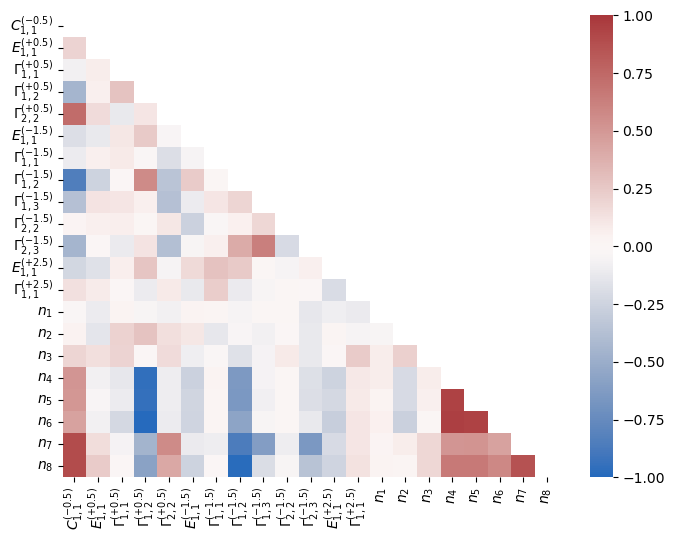

In [31]:
# Calculate the covariance matrix
cov = np.cov(chain, rowvar=False)
corr = np.corrcoef(chain, rowvar=False)
mask = np.triu( corr )

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
colormap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap( corr, vmin=-1, vmax=1, cmap=colormap, center=0, annot=False, fmt=".2f", mask=mask, xticklabels=azr.config.labels, yticklabels=azr.config.labels )

In [37]:
# All the data are in a single array, so we need to split them up
segments = azr.config.data.segments
lenghts = np.empty( shape=(len(segments)-1), dtype=int )
for idx, segment in enumerate(segments):
    if( idx == (len(segments) - 1) ): continue
    lenghts[idx] = len( segment.values )

x_split = np.split( x, np.cumsum(lenghts) )
y_split = np.split( y, np.cumsum(lenghts) )
dy_split = np.split( dy_bare, np.cumsum(lenghts) )

[ 1.64479156e+00  2.36822050e+00  3.58291230e+04 -4.91507254e-01
 -5.94070253e+03  3.50645957e+00  5.47541524e+04 -4.66478675e-01
  7.18021414e-04 -1.66161408e+02 -7.18454867e+02  3.54757595e+00
  4.70870397e+04  1.02196778e+00  1.00810460e+00  1.00476704e+00
  1.09613516e+00  1.08621783e+00  1.12974836e+00  1.08543643e+00
  7.79326089e-01]


In [38]:
# Number of samples
nsamples = 1000

# Sample the covariance matrix
samples = np.random.multivariate_normal( best, cov, nsamples )

# Calculate the S-factor for each sample
bucket = {}
for i in tqdm( range( nsamples ) ):
    output = np.vstack(azr.predict(samples[i], dress_up=False))
    output = np.split( output, np.cumsum(lenghts) )
    for idx in range( len( output ) ):
        if( idx not in bucket ): bucket[idx] = []
        else: bucket[idx].append( output[idx] )

100%|██████████| 1000/1000 [02:29<00:00,  6.68it/s]


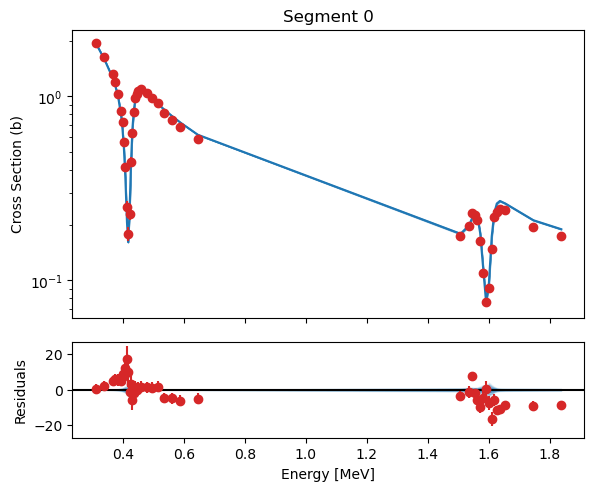

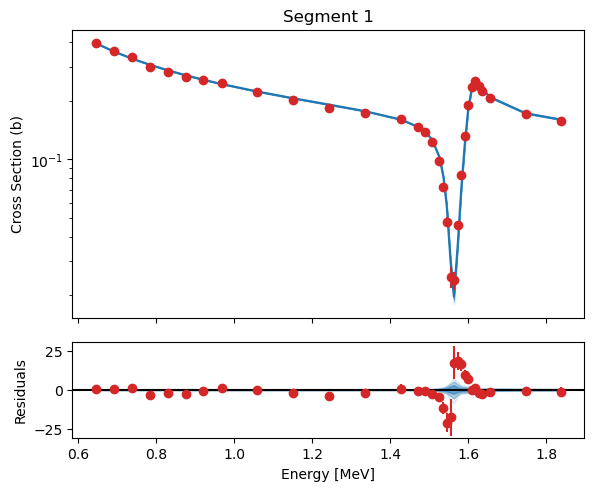

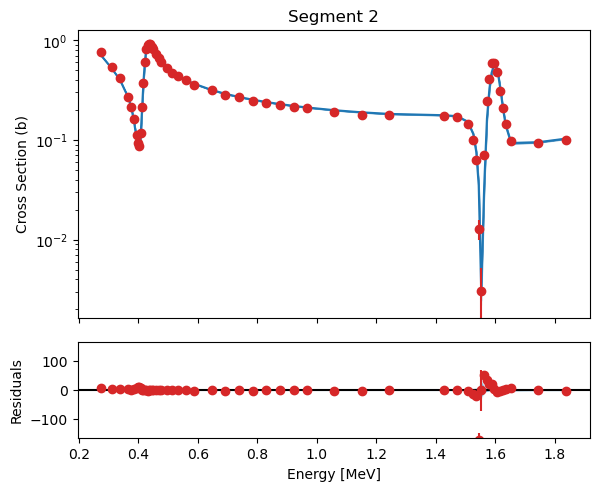

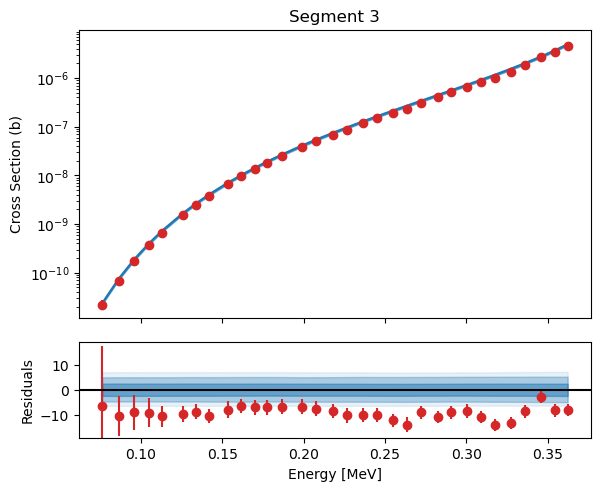

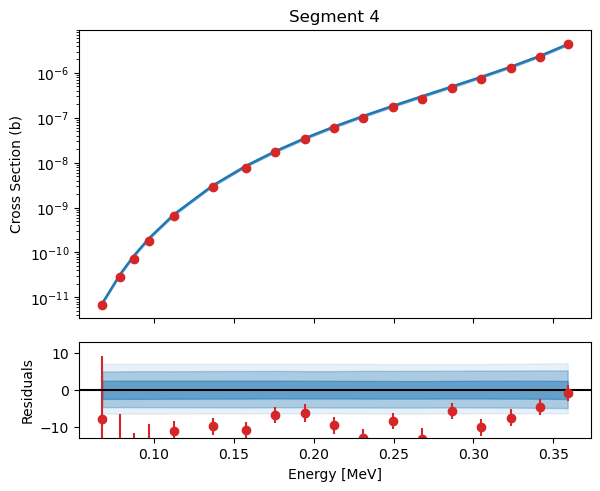

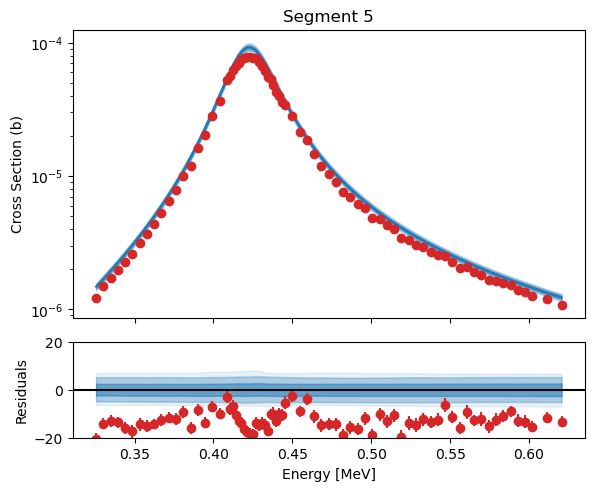

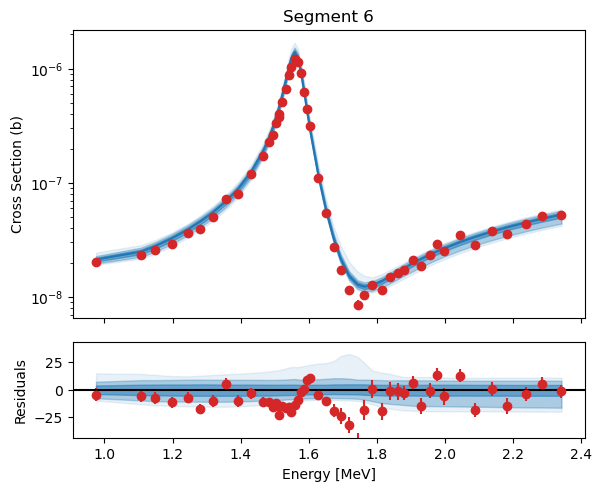

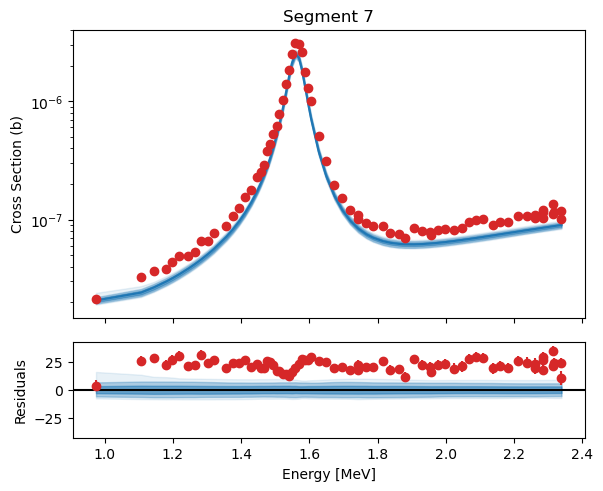

In [39]:
for i in range( len( segments ) ):

    # Now we plot the 1, 2 and 3 sigmas confidence intervals
    fig1 = plt.figure( )
    ax1 = fig1.add_axes((.1,.35,.8,.6))
    ax1.set_ylabel( "Cross Section (b)" )
    ax1.set_yscale( 'log' )
    ax1.set_xticklabels([])
    ax1.set_title( "Segment {}".format( i ) )

    bucket[i] = np.asarray( bucket[i] )

    quant_sigma1_low = np.zeros( len( x_split[i] ) )
    quant_sigma1_up  = np.zeros( len( x_split[i] ) )
    quant_sigma2_low = np.zeros( len( x_split[i] ) )
    quant_sigma2_up  = np.zeros( len( x_split[i] ) )
    quant_sigma3_low = np.zeros( len( x_split[i] ) )
    quant_sigma3_up  = np.zeros( len( x_split[i] ) )
    quant_mean       = np.zeros( len( x_split[i] ) )

    for j in range( len( x_split[i] ) ):
        quant_sigma1_low[j] = np.quantile( bucket[i][:,j,3], 0.158 )
        quant_sigma1_up[j]  = np.quantile( bucket[i][:,j,3], 0.841 )
        quant_sigma2_low[j] = np.quantile( bucket[i][:,j,3], 0.023 )
        quant_sigma2_up[j]  = np.quantile( bucket[i][:,j,3], 0.977 )
        quant_sigma3_low[j] = np.quantile( bucket[i][:,j,3], 0.002 )
        quant_sigma3_up[j]  = np.quantile( bucket[i][:,j,3], 0.998 )
        quant_mean[j]       = np.quantile( bucket[i][:,j,3], 0.5   )

    ax1.plot( x_split[i], quant_mean, color="tab:blue", label='Mean' )
    ax1.errorbar( x_split[i], y_split[i], yerr=dy_split[i], color="tab:red", fmt="o", label='{}'.format( labels[i] ) )
    ax1.fill_between( x_split[i], quant_sigma1_low, quant_sigma1_up, color="tab:blue", alpha=0.5, label='1 sigma' )
    ax1.fill_between( x_split[i], quant_sigma2_low, quant_sigma2_up, color="tab:blue", alpha=0.3, label='2 sigma' )
    ax1.fill_between( x_split[i], quant_sigma3_low, quant_sigma3_up, color="tab:blue", alpha=0.1, label='3 sigma' )

    percent = 100 * ( y_split[i] - quant_mean ) / y_split[i]
    percent_err = 100 * ( dy_split[i] / y_split[i] )
    max_percent = max( abs( percent + percent_err ) )

    ax2 = fig1.add_axes((.1,.1,.8,.2))
    ax2.errorbar( x_split[i], percent, yerr=percent_err, fmt="o", color="tab:red" )
    ax2.fill_between( x_split[i], 100 * ( quant_sigma1_low - quant_mean ) / quant_mean, 100 * ( quant_sigma1_up - quant_mean ) / quant_mean, color="tab:blue", alpha=0.5, label='1 sigma' )
    ax2.fill_between( x_split[i], 100 * ( quant_sigma2_low - quant_mean )/ quant_mean, 100 * ( quant_sigma2_up - quant_mean ) / quant_mean, color="tab:blue", alpha=0.3, label='2 sigma' )
    ax2.fill_between( x_split[i], 100 * ( quant_sigma3_low - quant_mean ) / quant_mean, 100 * ( quant_sigma3_up - quant_mean ) / quant_mean, color="tab:blue", alpha=0.1, label='3 sigma' )
    ax2.axhline( 0, color="black" )
    ax2.set_xlabel( "Energy [MeV]" )
    ax2.set_ylabel( "Residuals" )
    ax2.set_ylim( -max_percent * 1.1, max_percent * 1.1 )

plt.show( )